# Обучение LSTM-модели

In [2]:
!pip install gensim
!pip install pymorphy3
!pip install torcheval

In [3]:
import numpy as np
import pandas as pd
import re
import tqdm
import matplotlib.pyplot as plt

In [4]:
df_poems = pd.read_csv('poems_dataset.csv')
df_poems

,author,epoch,title,part,text
0,Агнивцев,серебряный век,брат антонио,0,"В монастырской тихой келье,\nПозабывши о весел..."
1,Агнивцев,серебряный век,грузовик 1317,0,"Весь машинный свой век, каждый день по утрам\n..."
2,Агнивцев,серебряный век,грузовик 1317,1,"Грузовик № 1317.\nНо открылись фронты! О, услы..."
3,Агнивцев,серебряный век,мэри пикфорд,0,"В Америке где-то\nСудя по газетам,\nЕсть город..."
4,Агнивцев,серебряный век,бильбокэ,0,"К дофину Франции, в печали,\nСкользнув тайком,..."
...,...,...,...,...,...
54232,Яшин,соцреализм,зеркальце,2,"В руки зеркальце взяла\nИ сказала:\n«Удружи,\n..."
54233,Яшин,соцреализм,очень много солнечного света,0,"Очень много солнечного света,\nНад землей стои..."
54234,Яшин,соцреализм,огонек,0,"Светлячок во мгле —\nОгонек в лесах.\nМожет, о..."
54235,Яшин,соцреализм,назови меня именем светлым,0,"Назови меня именем светлым,\nЧистым именем наз..."


## Эмбеддинги слов

Используем эмбеддинги `word2vec-ruscorpora-300` из библиотеки gensim. Для лемматизации и определения части речи, необходимых для работы с эмбеддингами, применим библиотеку pymorphy3.

In [5]:
import os
from pathlib import Path
import gensim.downloader
import nltk
import pymorphy3

In [6]:
os.environ['GENSIM_DATA_DIR'] = str(Path.cwd())
gensim_embeddings = gensim.downloader.load('word2vec-ruscorpora-300')
gensim_words = np.array([
    element.split('_') for element in gensim_embeddings.index_to_key
])
print('Parts of speech:')
print(np.unique(gensim_words[:, 1]))

Parts of speech:
['ADJ' 'ADP' 'ADV' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NUM' 'PART' 'PRON' 'VERB']


In [7]:
morph = pymorphy3.MorphAnalyzer()
tags_to_transform = {
    'ADJF': 'ADJ',
    'ADJS': 'ADJ',
    'COMP': 'ADJ',
    'INFN': 'VERB',
    'PRTF': 'VERB',
    'PRTS': 'VERB',
    'GRND': 'VERB',
    'NUMR': 'NUM',
    'ADVB': 'ADV',
    'PREP': 'ADP',
    'NPRO': 'PRON',
    'PRCL': 'PART',
    'CONJ': 'CCONJ',
}

def morph_parse(word):
    normal_form = morph.parse(word)[0].normal_form
    normal_form = re.sub('ё', 'е', normal_form)
    part_tag = re.findall(r'\w+', str(morph.parse(word)[0].tag))[0]
    if part_tag in tags_to_transform:
        part_tag = tags_to_transform[part_tag]
    return normal_form + '_' + part_tag

def get_embedding_tagged(tagged):
    if tagged in gensim_embeddings:
        return True, gensim_embeddings[tagged]
    else:
        return False, np.zeros(300)

def get_embedding(word):
    tagged = morph_parse(word)
    return get_embedding_tagged(tagged)

In [8]:
abs((get_embedding('стол')[1] * get_embedding('стул')[1]).sum())

0.70359695

In [9]:
class WordsEncoder:
    '''
    Объект преобразует русскоязычный текст в массив эмбеддингов слов.
    Эмбеддинги ранее встречавшихся слов запоминаются
    (на случай медленной работы gensim)
    '''

    def __init__(self):
        self._vocab = dict()
        self._vocab_occurances = dict()
        self._no_embedding_occurances = dict()

    def split(text):
        return re.findall(r'[а-яё]+', text.lower())

    def check(self, texts):
        '''Подсчет числа слов с эмбеддингами и без в текстах'''
        for text in tqdm.tqdm(texts):
            for word in WordsEncoder.split(text):
                tagged = morph_parse(word)
                if tagged in self._vocab_occurances:
                    self._vocab_occurances[tagged] += 1
                    continue
                if tagged in self._no_embedding_occurances:
                    self._no_embedding_occurances[tagged] += 1
                    continue
                success, embedding = get_embedding_tagged(tagged)
                if success:
                    self._vocab[tagged] = embedding
                    self._vocab_occurances[tagged] = 1
                else:
                    self._no_embedding_occurances[tagged] = 1

    def print_info(self):
        words_vocab = len(self._vocab)
        words_total = words_vocab + len(self._no_embedding_occurances)
        print('Processed unique words:', words_total)
        print('Of them with embeddings:', words_vocab, '({:.2f} %)'.format(
            words_vocab / words_total * 100.0
        ))
        self.vocab_occurances_list = pd.DataFrame(
            list(self._vocab_occurances.items()),
            columns=['word', 'occurances']
        )
        self.vocab_occurances_list.sort_values('occurances', ascending=False, inplace=True)
        self.no_embedding_occurances_list = pd.DataFrame(
            list(self._no_embedding_occurances.items()),
            columns=['word', 'occurances']
        )
        self.no_embedding_occurances_list.sort_values('occurances', ascending=False, inplace=True)
        occurances_vocab = self.vocab_occurances_list['occurances'].sum()
        occurances_total = occurances_vocab + self.no_embedding_occurances_list['occurances'].sum()
        print('Processed word occurances:', occurances_total)
        print('Of them with embeddings:', occurances_vocab, '({:.2f} %)'.format(
            occurances_vocab / occurances_total * 100.0
        ))

    def to_embeddings(self, text):
        embeddings = []
        for word in WordsEncoder.split(text):
            tagged = morph_parse(word)
            if tagged in self._vocab_occurances:
                embeddings.append(self._vocab[tagged])
                continue
            if tagged in self._no_embedding_occurances:
                continue
            success, embedding = get_embedding_tagged(tagged)
            if success:
                self._vocab[tagged] = embedding
                embeddings.append(self._vocab[tagged])
                self._vocab_occurances[tagged] = 0
            else:
                self._no_embedding_occurances[tagged] = 0
        return np.array(embeddings)

    def batch_to_embeddings(self, texts):
        length = np.zeros(len(texts), dtype=int)
        result = []
        for i, text in enumerate(texts):
            result.append(self.to_embeddings(text))
            length[i] = len(result[-1])
        length_max = max(1, length.max())
        for i in range(len(result)):
            if length[i] == 0:
                result[i] = np.zeros((length_max, 300))
                length[i] = 1
                continue
            result[i] = np.concatenate([
                result[i],
                np.zeros((length_max - length[i], 300))
            ], axis=0)
        result = np.array(result).transpose(1, 0, 2)
        return result, length

In [10]:
words_encoder = WordsEncoder()

In [11]:
words_encoder.check(df_poems['text'])
words_encoder.print_info()

100%|██████████| 54237/54237 [25:10<00:00, 35.91it/s]


Processed unique words: 89467
Of them with embeddings: 50713 (56.68 %)
Processed word occurances: 4704553
Of them with embeddings: 2593569 (55.13 %)


In [12]:
words_encoder.vocab_occurances_list.head(10)

,word,occurances
58,день_NOUN,12396
451,душа_NOUN,11210
209,сердце_NOUN,10713
545,мочь_VERB,10097
988,знать_VERB,9494
483,рука_NOUN,9449
650,жизнь_NOUN,9229
23,друг_NOUN,8272
249,любовь_NOUN,8130
143,земля_NOUN,7976


In [13]:
words_encoder.no_embedding_occurances_list.head(10)

,word,occurances
5,и_CCONJ,207530
0,в_ADP,147989
72,я_PRON,112170
53,не_PART,89995
16,на_ADP,61038
116,ты_PRON,57790
34,с_ADP,55580
32,он_PRON,49928
8,как_CCONJ,46819
74,что_CCONJ,41062


Самые частые слова без эмбеддингов в контексте автоматической обработки текста не несут смысла и могут считаться стоп-словами. Они будут игнорироваться автоматически.

## LSTM

Поверх эмбеддингов используется LSTM-модель. Применим известную реализацию из библиотеки pytorch.

In [15]:
import torch
from torch import nn, optim
from torch.utils import data
import time
from sklearn.metrics import accuracy_score, f1_score

In [16]:
class DataFrameDataset(data.Dataset):
    def __init__(self, df):
        self._df = df

    def __getitem__(self, index):
        row = self._df.iloc[index]
        return row.iloc[0], row.iloc[1]

    def __len__(self):
        return len(self._df)

In [17]:
class LabelEncoder:
    def __init__(self, labels):
        self._index_to_label = np.array(labels)
        self._label_to_index = pd.DataFrame(np.arange(len(labels)), index=labels)

    def encode(self, arr_labels):
        return self._label_to_index.loc[arr_labels].to_numpy()

    def decode(self, arr_indices):
        return self._index_to_label[arr_indices]

    def number_classes(self):
        return len(self._index_to_label)

In [18]:
label_encoder = LabelEncoder(df_poems['epoch'].unique())
df_poems['epoch_encoded'] = label_encoder.encode(df_poems['epoch'])
label_encoder.number_classes()

7

In [19]:
torch.manual_seed(1234)
dataset = DataFrameDataset(df_poems[['text', 'epoch_encoded']])
data_train, data_eval, data_test = data.random_split(dataset, [0.7, 0.15, 0.15])
loader_train = data.DataLoader(data_train, batch_size=100, shuffle=True)
loader_eval = data.DataLoader(data_eval, batch_size=100)
loader_test = data.DataLoader(data_test, batch_size=100)

In [20]:
df_labels = pd.concat([
    df_poems.loc[data_train.indices].groupby('epoch').size(),
    df_poems.loc[data_eval.indices].groupby('epoch').size(),
    df_poems.loc[data_test.indices].groupby('epoch').size()
], axis=1)
df_labels.columns = ['train', 'eval', 'test']
df_labels

,train,eval,test
epoch,,,
золотой век,6019,1260,1282
классицизм,2295,490,496
критический реализм,6634,1351,1443
серебряный век,11272,2529,2403
соцреализм,4105,919,859
футуризм,5352,1118,1172
шестидесятники,2289,469,480


In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, words_encoder):
        super(LSTMModel, self).__init__()
        self._lstm = nn.LSTM(input_dim, hidden_dim, layer_dim)
        self._linear = nn.Linear(hidden_dim, output_dim)
        self._log_softmax = nn.LogSoftmax(dim=1)
        self._words_encoder = words_encoder

    def forward(self, texts_batch):
        embeddings, length = self._words_encoder.batch_to_embeddings(texts_batch)
        embeddings = torch.Tensor(embeddings)
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(embeddings, length, enforce_sorted=False)
        out, (hidden, cell) = self._lstm(packed_embeddings)
        result = self._linear(hidden[0])
        result = self._log_softmax(result)
        return result

Модель вполне стандартна. Входные векторы имеют длину $300$ -- по размерности эмбеддингов. Внутреннее состояние взято чуть большим: длины $400$. Нейросеть содержит единственный скрытый слой. Число выходов $7$ -- по количеству предсказываемых классов.

In [37]:
torch.manual_seed(1234)
lstm = LSTMModel(300, 400, 1, 7, words_encoder)

In [38]:
optimizer = optim.Adam(lstm.parameters(), lr=1.5e-4)
loss_function = nn.CrossEntropyLoss()

In [39]:
def model_eval(model, loader, loss_function):
    losses = []
    accuracies = []
    for batch_feature, batch_label in loader:
        predictions = lstm(batch_feature)
        loss = loss_function(predictions, batch_label)
        losses.append(loss.item())
        accuracies.append(accuracy_score(batch_label, predictions.argmax(axis=1)))
    return np.array(losses).mean(), np.array(accuracies).mean()

In [40]:
def model_train(model, loader_train, loader_eval, loss_function, optimizer):
    loss_eval = []
    accuracy_eval = []
    for epoch_index in range(3):
        epoch_begin = time.time()
        print('---------- Epoch {} ----------'.format(epoch_index))
        for i, (batch_feature, batch_label) in enumerate(loader_train):
            optimizer.zero_grad()
            predictions = lstm(batch_feature)
            loss = loss_function(predictions, batch_label)
            loss.backward()
            optimizer.step()
            if i % 50 == 0:
                print('Iteration {}.\tLoss: {:.4f}'.format(i, loss.item()))
        epoch_end = time.time()
        loss, accuracy = model_eval(model, loader_eval, loss_function)
        loss_eval.append(loss)
        accuracy_eval.append(accuracy)
        print('\nEvaluation loss: {:.4f}'.format(loss_eval[-1]))
        print('Evaluation accuracy: {:.3f}'.format(accuracy_eval[-1]))
        print('Training time: {:.2f} s; per batch: {:.2e} s\n'.format(
            epoch_end - epoch_begin,
            (epoch_end - epoch_begin) / len(loader_train)
        ))
        epoch_index += 1

In [41]:
model_train(lstm, loader_train, loader_eval, loss_function, optimizer)

---------- Epoch 0 ----------
Iteration 0.	Loss: 1.9544
Iteration 50.	Loss: 1.7965
Iteration 100.	Loss: 1.8249
Iteration 150.	Loss: 1.7033
Iteration 200.	Loss: 1.7541
Iteration 250.	Loss: 1.5710
Iteration 300.	Loss: 1.5601
Iteration 350.	Loss: 1.5868

Evaluation loss: 1.4360
Evaluation accuracy: 0.451
Training time: 1776.64 s; per batch: 4.68e+00 s

---------- Epoch 1 ----------
Iteration 0.	Loss: 1.5037
Iteration 50.	Loss: 1.3604
Iteration 100.	Loss: 1.3105
Iteration 150.	Loss: 1.4973
Iteration 200.	Loss: 1.4138
Iteration 250.	Loss: 1.3472
Iteration 300.	Loss: 1.4545
Iteration 350.	Loss: 1.3067

Evaluation loss: 1.2900
Evaluation accuracy: 0.509
Training time: 1768.82 s; per batch: 4.65e+00 s

---------- Epoch 2 ----------
Iteration 0.	Loss: 1.3842
Iteration 50.	Loss: 1.2375
Iteration 100.	Loss: 1.2246
Iteration 150.	Loss: 1.2977
Iteration 200.	Loss: 1.3283
Iteration 250.	Loss: 1.2134
Iteration 300.	Loss: 1.2801
Iteration 350.	Loss: 1.1764

Evaluation loss: 1.2139
Evaluation accuracy:

In [48]:
torch.save(lstm.state_dict(), 'lstm_poems.pt')

## Тестирование модели

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
lstm = LSTMModel(300, 400, 1, 7, words_encoder)
lstm.load_state_dict(torch.load('lstm_poems.pt'))

<All keys matched successfully>

In [51]:
def model_test(model, loader, loss_function):
    losses = []
    labels = []
    predictions = []
    for batch_feature, batch_label in loader:
        batch_prediction = lstm(batch_feature)
        loss = loss_function(batch_prediction, batch_label)
        losses.append(loss.item())
        labels += batch_label
        predictions += batch_prediction.argmax(axis=1)
    labels = np.array(labels)
    predictions = np.array(predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    print('Accuracy:\t{:.3f}'.format(accuracy))
    print('F1 (weighted):\t{:.3f}'.format(f1))
    return labels, predictions

In [52]:
labels, predictions = model_test(lstm, loader_test, loss_function)

Accuracy:	0.543
F1 (weighted):	0.514


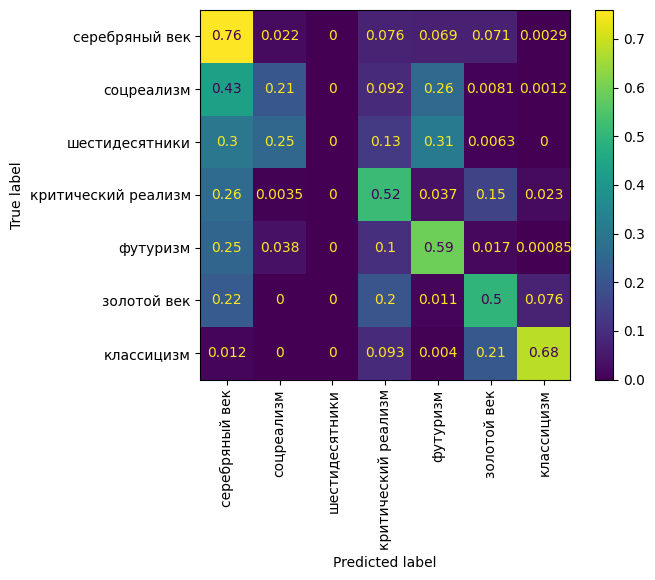

In [53]:
cm = confusion_matrix(labels, predictions, normalize='true')
ConfusionMatrixDisplay(
    cm,
    display_labels=label_encoder.decode(np.arange(7))
).plot(xticks_rotation = 'vertical')